05 — Model Evaluation & Inference

This notebook evaluates the ResNet18 model trained in Notebook 04. The goal is to measure how well the model performs on unseen images and understand where it succeeds or struggles.

What’s included:
1. Load the trained model: 
    Rebuild the ResNet18 architecture and load the saved .pth weights.
2. Prepare the test dataset: 
    Apply the same transforms used during validation and load images for evaluation.
3. Compute test accuracy: 
    Measure the model’s performance on unseen data.
4. Confusion matrix: 
    Visualize which classes the model predicts correctly and which ones it mixes up.
5. Sample predictions: 
    Display test images with true and predicted labels.
6. Misclassified samples: 
    Inspect the images the model got wrong to understand common mistakes.
7. Custom image inference: 
    Test the model on your own image to see how it performs outside the dataset.

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader

import matplotlib as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
import os

import sys
sys.path.append("..")
from dataset import PlantVillageDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
#transforms

test_transforms = transforms.Compose([
  transforms.Resize((160,160)),
  transforms.ToTensor(),
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229,0.224,0.225]
  )
])

test_dataset = PlantVillageDataset(
  "../data/PlantVillage/val",
  transform=test_transforms
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")


Test samples: 10861
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spid

In [3]:
model = models.resnet18(weights=None) #no pretrained weights
num_classes = len(test_dataset.classes)
model.fc = nn.Linear(512, num_classes)

#load trained weights
model.load_state_dict(torch.load("../models/resnet18_best.pth", map_location=device))
model = model.to(device)
model.eval() #evalualion mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
#compute accuracy
correct = 0 
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _,preds = torch.max(outputs, 1)

    correct += (preds == labels).sum().item()
    total += labels.size(0)
test_acc = correct / total
print(f"Final Test Accuracy: {test_acc:.4f}")

Final Test Accuracy: 0.9917


In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# hard reset in case style packages overwrote plt
plt = matplotlib.pyplot


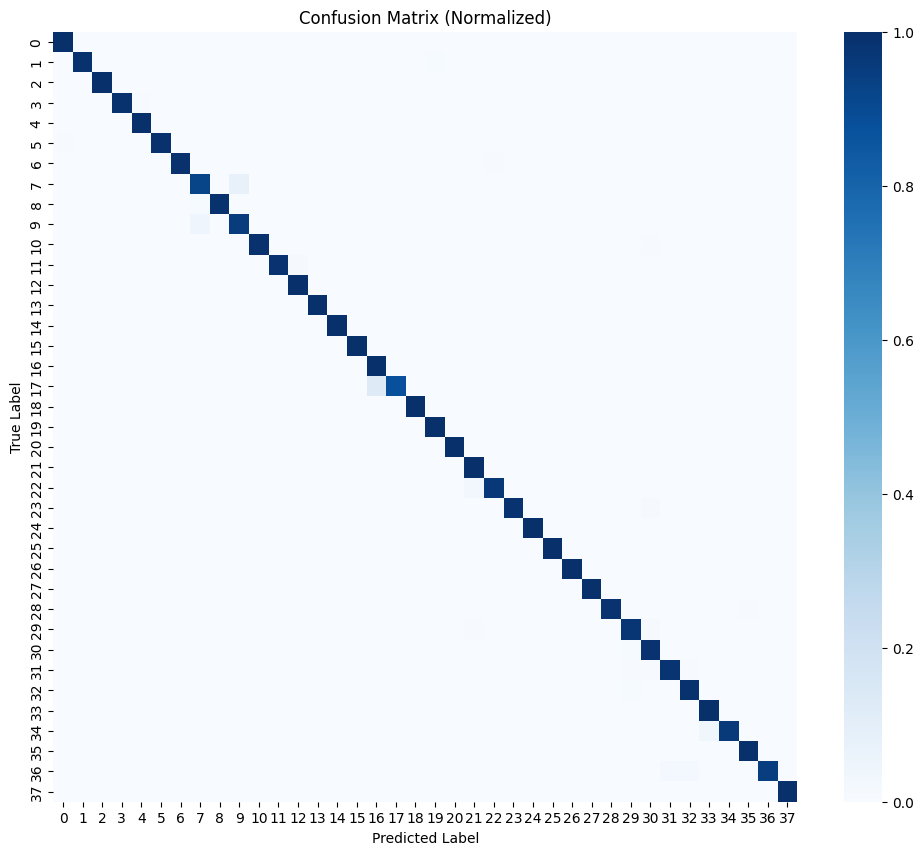

In [7]:
#confusion matrix -> table that shows how model actually performed for each class
#each row reps what leaf actually is
#each col reps what the model guessed

all_preds = []
all_targets = []

#not training, so no gradients are computed
with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    outputs = model(images) #get model preds

    #torch_max(...,1) returns:
    # preds = idx of highest score -> pred class
    _, preds = torch.max(outputs, 1)

    #save preds and true labels into py lists
    #just incase it does use gpu, we need to move to cpu since numoy needs it
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

#build confusion mtx
cm = confusion_matrix(all_targets, all_preds)

#normalize so each row values are in range 0-1
#shows % of preds per class
cm_norm = cm / cm.sum(axis=1, keepdims=True)

#plot
plt.figure(figsize=(12,10))
sns.heatmap(cm_norm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (Normalized)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7172985..2.0299783].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6998693..1.3956583].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..1.733682].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.0888019].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..1.8905448].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.4831376].


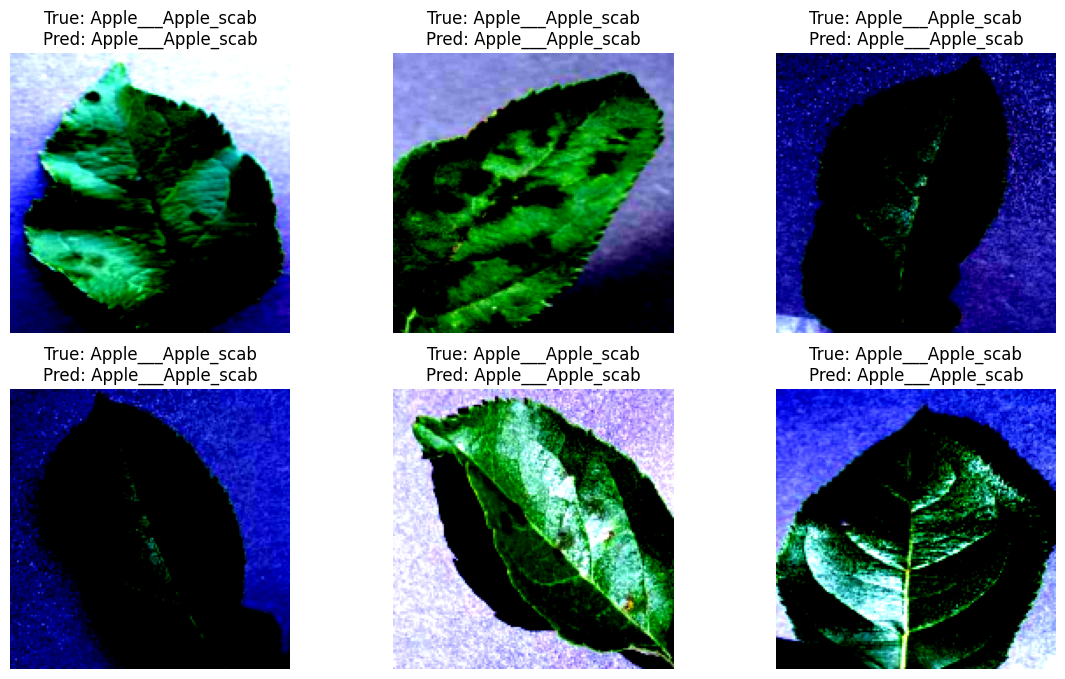

In [8]:
def show_preds(model, dataset, num_imgs=6):
  model.eval()
  plt.figure(figsize=(14,8))

  for i in range(num_imgs):
    img,label = dataset[i]
    img_display = img.permute(1,2,0) # convert from tensor CHW to HWC
    img_batch = img.unsqueeze(0).to(device)

    with torch.no_grad():
      output = model(img_batch)
      _,pred  = torch.max(output, 1)

      true_class = dataset.classes[label]
      pred_class = dataset.classes[pred.item()]

      plt.subplot(2,3,i+1)
      plt.imshow(img_display)
      plt.title(f"True: {true_class}\nPred: {pred_class}")
      plt.axis("off")

  plt.show()

show_preds(model, test_dataset, num_imgs=6)

In [9]:
misclassified = []

with torch.no_grad():
  for i in range(len(test_dataset)):
    img, label = test_dataset[i]
    batch = img.unsqueeze(0).to(device)

    output = model(batch)
    _,pred = torch.max(output,1)

    if pred.item() != label:
      misclassified.append((img, label, pred.item()))

print(f"Total misclassified: {len(misclassified)}")

Total misclassified: 90


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6650109..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9466565..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.2535014].


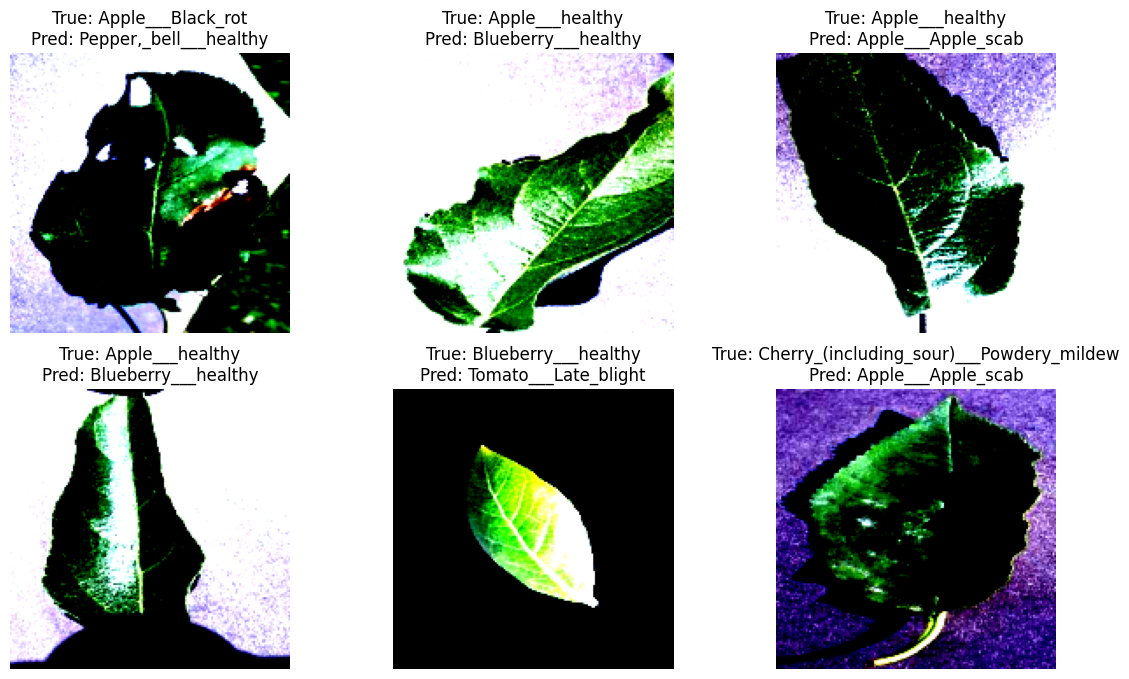

In [10]:
def show_misclassified(misclassified, num=6):
  if len(misclassified) == 0:
    print("No misclassified sample!!")
    return
  plt.figure(figsize=(14,8))

  for i in range(min(num, len(misclassified))):
    img, true_lbl, pred_lbl = misclassified[i]

    img_disp = img.permute(1,2,0)

    plt.subplot(2,3,i+1)
    plt.imshow(img_disp)

    plt.title(f"True: {test_dataset.classes[true_lbl]}\nPred: {test_dataset.classes[pred_lbl]}")
    plt.axis("off")
  plt.show()

show_misclassified(misclassified, num=6)

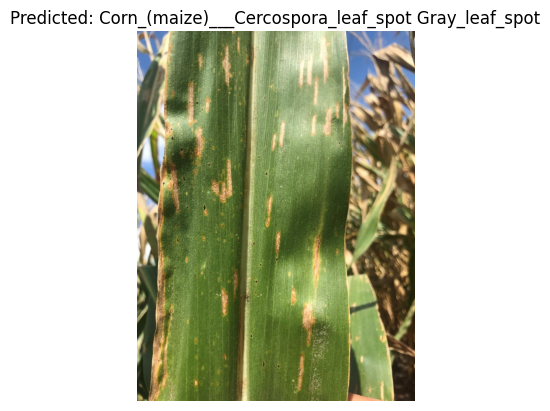

In [14]:
#custom image

def predict_img(model, img_path, transform=test_transforms):
  model.eval()
  img = Image.open(img_path).convert("RGB")
  img_tensor = transform(img).unsqueeze(0).to(device)

  with torch.no_grad():
    output = model(img_tensor)
    _,pred = torch.max(output,1)

  predicated_class = test_dataset.classes[pred.item()]
  return img, predicated_class

img, prediction = predict_img(model, "../data/custom_leaf.jpg")

plt.imshow(img)
plt.title(f"Predicted: {prediction}")
plt.axis("off")
plt.show()


In [12]:
torch.save(model.state_dict(), "../models/resnet18_final.pth")